# Imports

In [1]:
import numpy as np
import pandas as pd
import dowhy
import dowhy.datasets
import dowhy.plotter
from dowhy import gcm
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# For SCM/PCM fitting
from sklearn.linear_model import LinearRegression
from dowhy.gcm.stochastic_models import EmpiricalDistribution
from dowhy.gcm.causal_mechanisms import AdditiveNoiseModel

# For DoubleML
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR

# Define FAPS colours 
fapsgreen    = "#97C139"   # from (151,193,57)
fapsblue     = "#296193"   # from (41,97,147)
fapsdarkgray = "#5F5F5F"   # from (95,95,95)
darkgray     = "#CCCCCC"   # from (204,204,204)
lightgray    = "#E5E5E5"   # from (229,229,229)

# Set the random seed for reproducibility
np.random.seed(42)

# Load and Prepare Dataset

In [2]:
# Set the path to your dataset file
df = pd.read_csv('./dataset.csv')

# Define the selected columns (including meta columns)
select_cols = [
    'DXP_HoldingPressure1',
    'E77_BarrelTemperatureZone6',
    'E77_TransferStroke',
    'E77_CushionVolume',
    'E77_DosingTime',
    'DXP_AreaCavityPressure',
    'SCA_PartWeight',
    'E77_CavityPressureMaximum',
    'MET_MachineCycleID',
    'MET_MaterialName'
]
df = df[select_cols]

# Filter for PP material and drop meta columns
df = df[df['MET_MaterialName'] == 'PP'].copy()
df.drop(columns=['MET_MaterialName', 'MET_MachineCycleID'], inplace=True)

# Min-max normalization
normalized_df = (df - df.min()) / (df.max() - df.min())
df = normalized_df.copy()

# Define Common Variables and DAG

C:\Users\rejin\AppData\Local\Temp\ipykernel_15052\3876409827.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


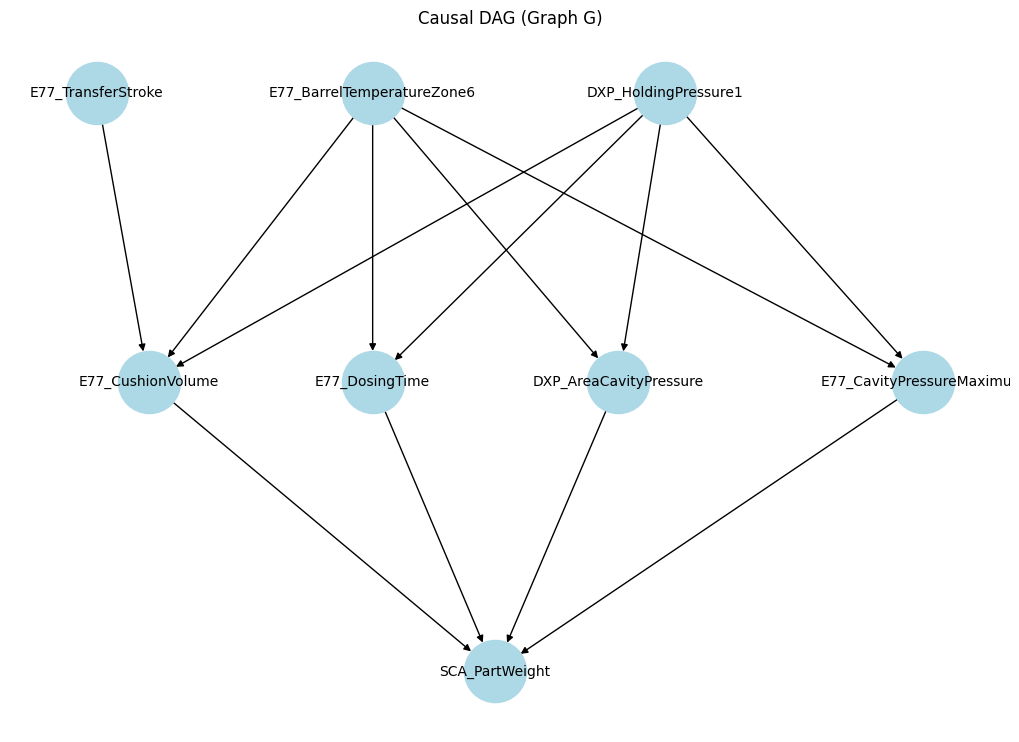

In [3]:
# Outcome and treatment variables
outcome = 'SCA_PartWeight'
treatment_vars = [
    'E77_CushionVolume',
    'E77_DosingTime',
    'DXP_AreaCavityPressure',
    'E77_CavityPressureMaximum'
]

# Define the DAG in DOT format
graph_def_G = """
digraph {
    E77_DosingTime -> SCA_PartWeight;
    E77_CushionVolume -> SCA_PartWeight;
    DXP_AreaCavityPressure -> SCA_PartWeight;
    E77_CavityPressureMaximum -> SCA_PartWeight;
    DXP_HoldingPressure1 -> E77_DosingTime;
    E77_BarrelTemperatureZone6 -> E77_DosingTime;
    DXP_HoldingPressure1 -> E77_CushionVolume;
    E77_BarrelTemperatureZone6 -> E77_CushionVolume;
    E77_TransferStroke -> E77_CushionVolume;
    DXP_HoldingPressure1 -> E77_CavityPressureMaximum;
    E77_BarrelTemperatureZone6 -> E77_CavityPressureMaximum;
    DXP_HoldingPressure1 -> DXP_AreaCavityPressure;
    E77_BarrelTemperatureZone6 -> DXP_AreaCavityPressure;
}
"""

# Create the NetworkX graph from the DOT definition
(graph_dot,) = pydot.graph_from_dot_data(graph_def_G)
G = nx.DiGraph(nx.drawing.nx_pydot.from_pydot(graph_dot))

# Optionally, visualize the DAG
pos = graphviz_layout(G, prog='dot')
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, arrows=True)
plt.title("Causal DAG (Graph G)")
plt.tight_layout()
plt.show()

# Method 1: DoWhy with Backdoor Linear Regression

In [4]:
# Here we create individual DoWhy models (one per treatment) and estimate the causal effect using the backdoor criterion.

def create_individual_models(data, graph_def, treatment_vars, outcome_var):
    models = {}
    for treatment in treatment_vars:
        model = dowhy.CausalModel(
            data=data,
            graph=graph_def,
            treatment=treatment,
            outcome=outcome_var
        )
        models[treatment] = model
    return models

def estimate_effects(models):
    effects = {}
    for treatment, model in models.items():
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            warnings.filterwarnings("ignore", category=FutureWarning)
            identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
            estimate = model.estimate_effect(
                identified_estimand,
                method_name="backdoor.linear_regression",
                test_significance=True
            )
        effects[treatment] = {
            'Dowhy_Effect': estimate.value,
            'Dowhy_Pvalue': estimate.test_stat_significance()['p_value']
        }
    return effects

# Create models and estimate effects
models_dowhy = create_individual_models(df, graph_def_G, treatment_vars, outcome)
effects_dowhy = estimate_effects(models_dowhy)

# Methods 2 & 3: SCM and PCM with Interventions

In [5]:
# Define a minimal wrapper for sklearn's LinearRegression for the AdditiveNoiseModel
class LinearRegressionWrapper:
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X, Y):
        self.model.fit(X, Y)

    def predict(self, X):
        return self.model.predict(X)

def create_and_fit_scm(graph, data):
    scm = gcm.StructuralCausalModel(graph)
    for node in graph.nodes():
        if graph.in_degree(node) == 0:
            scm.set_causal_mechanism(node, EmpiricalDistribution())
        else:
            linear_model = AdditiveNoiseModel(
                prediction_model=LinearRegressionWrapper(),
                noise_model=EmpiricalDistribution()
            )
            scm.set_causal_mechanism(node, linear_model)
    gcm.fit(scm, data)
    return scm

def create_and_fit_pcm(graph, data):
    pcm = gcm.ProbabilisticCausalModel(graph)
    for node in graph.nodes():
        if graph.in_degree(node) == 0:
            pcm.set_causal_mechanism(node, EmpiricalDistribution())
        else:
            linear_model = AdditiveNoiseModel(
                prediction_model=LinearRegressionWrapper(),
                noise_model=EmpiricalDistribution()
            )
            pcm.set_causal_mechanism(node, linear_model)
    gcm.fit(pcm, data)
    return pcm

def estimate_causal_effect(model, target_node, treatment_node, data, low_value, high_value, use_drawn_samples=True, num_samples=1000):
    intervention_reference = {treatment_node: lambda x: low_value}
    intervention_alternative = {treatment_node: lambda x: high_value}
    kwargs = {'num_samples_to_draw': num_samples} if use_drawn_samples else {'observed_data': data}
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        ace = gcm.average_causal_effect(
            model,
            target_node=target_node,
            interventions_alternative=intervention_alternative,
            interventions_reference=intervention_reference,
            **kwargs
        )
    return ace

# Create and fit the SCM and PCM using the graph G and the data df
scm_G = create_and_fit_scm(G, df)
pcm_G = create_and_fit_pcm(G, df)

# For each treatment, estimate the ATE (using drawn samples) for both SCM and PCM.
scm_results = {}
pcm_results = {}
target_node = outcome
for param in treatment_vars:
    low_val = df[param].min()
    high_val = df[param].max()
    scm_ate = estimate_causal_effect(scm_G, target_node, param, df, low_val, high_val, use_drawn_samples=True, num_samples=1000)
    pcm_ate = estimate_causal_effect(pcm_G, target_node, param, df, low_val, high_val, use_drawn_samples=True, num_samples=1000)
    scm_results[param] = scm_ate
    pcm_results[param] = pcm_ate

Fitting causal models:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting causal mechanism of node E77_TransferStroke: 100%|██████████| 8/8 [00:00<00:00, 22.34it/s]        
Fitting causal mechanism of node E77_TransferStroke: 100%|██████████| 8/8 [00:00<00:00, 497.92it/s]


# Method 4: Double Machine Learning (DoubleML)

In [6]:
# Define covariates (confounders)
covariates = [
    'DXP_HoldingPressure1',
    'E77_BarrelTemperatureZone6',
    'E77_TransferStroke'
]

# Prepare the DoubleMLData object
dml_data = DoubleMLData(
    data=df,
    y_col=outcome,
    d_cols=treatment_vars,
    x_cols=covariates
)

# Initialize machine learning models for the nuisance parameters
ml_g = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=11)
ml_m = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=11)

# Initialize and fit the DoubleMLPLR estimator
dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)
dml_plr.fit()

# The DoubleML estimator returns coefficients and p-values (one per treatment).
doubleml_effects = {treatment: {'DoubleML_ATE': coef, 'DoubleML_Pvalue': pval}
                    for treatment, coef, pval in zip(treatment_vars, dml_plr.coef, dml_plr.pval)}

# Combine Results into a Single DataFrame

In [7]:
# Create a list to hold the combined results
results = []

for treatment in treatment_vars:
    row = {
        'Treatment': treatment,
        # Method 1: DoWhy
        'Dowhy_Effect': effects_dowhy[treatment]['Dowhy_Effect'],
        'Dowhy_Pvalue': effects_dowhy[treatment]['Dowhy_Pvalue'],
        # Method 2: SCM (using drawn samples)
        'SCM_ATE': scm_results[treatment],
        # Method 3: PCM (using drawn samples)
        'PCM_ATE': pcm_results[treatment],
        # Method 4: DoubleML
        'DoubleML_ATE': doubleml_effects[treatment]['DoubleML_ATE'],
        'DoubleML_Pvalue': doubleml_effects[treatment]['DoubleML_Pvalue']
    }
    results.append(row)

# Create a DataFrame from the results
df_causal_estimates = pd.DataFrame(results)
print("\nCombined Causal Estimation Results:")
df_causal_estimates


Combined Causal Estimation Results:


,Treatment,Dowhy_Effect,Dowhy_Pvalue,SCM_ATE,PCM_ATE,DoubleML_ATE,DoubleML_Pvalue
0,E77_CushionVolume,-0.986497,[1.4316731580012214e-24],-0.237714,-0.238316,-0.110588,0.134479
1,E77_DosingTime,0.288869,[1.961092337622669e-14],0.096706,0.097574,0.010292,0.527112
2,DXP_AreaCavityPressure,-0.308382,[3.581940470222561e-31],-0.464537,-0.465812,-0.338863,0.002093
3,E77_CavityPressureMaximum,0.959156,[2.468224048448485e-16],0.981892,0.981478,0.454830,0.012546


## Visualization

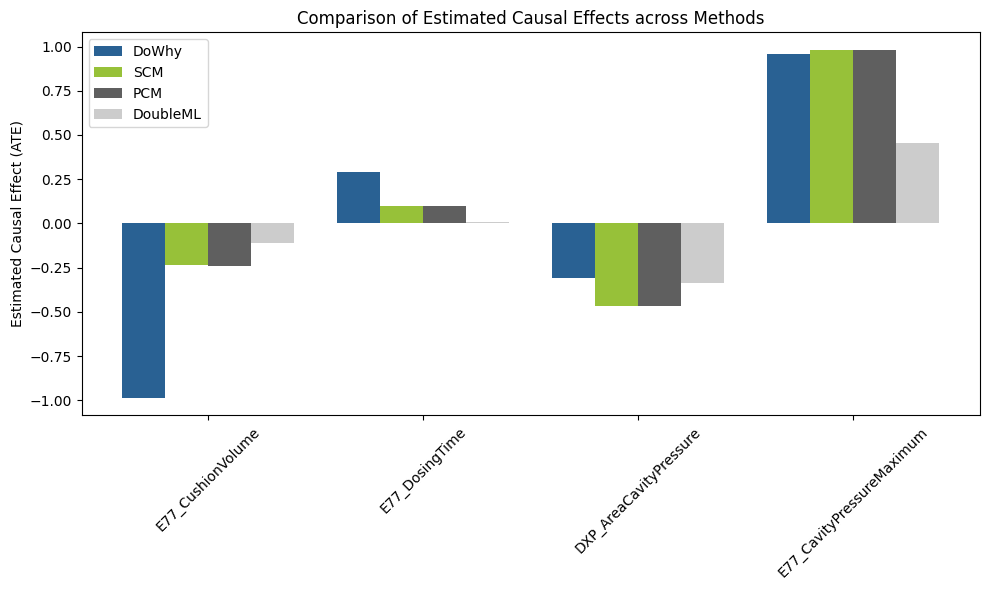

In [8]:
# Prepare data for plotting
x = np.arange(len(treatment_vars))  # one tick per treatment
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each method using the FAPS colours
ax.bar(x - 1.5*width, df_causal_estimates['Dowhy_Effect'], width,
       label='DoWhy', color=fapsblue)
ax.bar(x - 0.5*width, df_causal_estimates['SCM_ATE'], width,
       label='SCM', color=fapsgreen)
ax.bar(x + 0.5*width, df_causal_estimates['PCM_ATE'], width,
       label='PCM', color=fapsdarkgray)
ax.bar(x + 1.5*width, df_causal_estimates['DoubleML_ATE'], width,
       label='DoubleML', color=darkgray)

# Customize the axes and add labels
ax.set_xticks(x)
ax.set_xticklabels(df_causal_estimates['Treatment'], rotation=45)
ax.set_ylabel("Estimated Causal Effect (ATE)")
ax.set_title("Comparison of Estimated Causal Effects across Methods")
ax.legend()

plt.tight_layout()
plt.show()